In [1]:
from atmospheric_explorer.cams_interfaces import InversionOptimisedGreenhouseGas, EAC4Instance
from atmospheric_explorer.shapefile import ShapefilesDownloader
from atmospheric_explorer.utils import get_local_folder
from atmospheric_explorer.units_conversion import convert_units_array
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import xarray as xr
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray
import plotly.graph_objects as go
import shutil
import numpy as np
import statsmodels.stats.api as sms
import pandas as pd
import cdsapi
from atmospheric_explorer.plotting_apis import eac4_hovmoeller_levels_plot
from atmospheric_explorer.data_transformations import clip_and_concat_countries, shifting_long

2023-07-24 10:16:36,761 INFO Loaded constants from file constants.cfg
2023-07-24 10:16:36,765 INFO Evaluating arithmetic formulas in config
2023-07-24 10:16:36,769 DEBUG Parsing 1
2023-07-24 10:16:36,773 DEBUG Parsing 1
2023-07-24 10:16:36,776 DEBUG Parsing 1
2023-07-24 10:16:36,779 DEBUG Parsing 1
2023-07-24 10:16:36,782 DEBUG Parsing 1
2023-07-24 10:16:36,785 DEBUG Parsing 1
2023-07-24 10:16:36,788 DEBUG Parsing 1
2023-07-24 10:16:36,791 DEBUG Parsing 1
2023-07-24 10:16:36,796 DEBUG Parsing 1
2023-07-24 10:16:36,798 DEBUG Parsing 1
2023-07-24 10:16:36,802 DEBUG Parsing 1
2023-07-24 10:16:36,804 DEBUG Parsing 1
2023-07-24 10:16:36,807 DEBUG Parsing 1
2023-07-24 10:16:36,810 DEBUG Parsing 1
2023-07-24 10:16:36,813 DEBUG Parsing 1
2023-07-24 10:16:36,816 DEBUG Parsing 1
2023-07-24 10:16:36,819 DEBUG Parsing 1
2023-07-24 10:16:36,822 DEBUG Parsing 1
2023-07-24 10:16:36,825 DEBUG Parsing 1
2023-07-24 10:16:36,829 DEBUG Parsing 1
2023-07-24 10:16:36,831 DEBUG Parsing 1
2023-07-24 10:16:36,

In [ ]:
# Remove previous data
shutil.rmtree(os.path.join(get_local_folder(), 'data'))

In [ ]:
# Remove previous data
shutil.rmtree(os.path.join(get_local_folder(), 'shapefiles'))

In [8]:
#function to move from 0+360 to -180+180 long
def ds_swaplon(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

In [ ]:
manager = InversionOptimisedGreenhouseGas(
    data_variables='carbon_dioxide',
    file_format='zip',
    quantity='surface_flux',
    input_observations='surface',
    time_aggregation='monthly_mean',
    year=[
        '1985', '1986', '1987',
        '1988', '1989', '1990',
        '1991', '1992', '1993',
        '1994', '1995', '1996',
        '1997', '1998', '1999',
        '2000', '2001', '2002',
        '2003', '2004', '2005',
        '2006', '2007', '2008',
        '2009', '2010', '2011',
        '2012', '2013', '2014',
        '2015', '2016', '2017',
        '2018', '2019', '2020'
    ],
    month=[
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12'
    ]
)
manager.download()

In [ ]:
#sorted: ordina in ordine alfabetico  - globe: dentro è una lista (casting=viene 'converitito' in una lista)
files = sorted(glob(manager.file_full_path))

In [ ]:
#cos'è un genereatore:
gen=(i for i in range(10))
#lista invece:
lista=[i for i in range(10)]

#come si scrive la lista [] o il generatore () si chiama list comprehension: permette di definire l'oggetto semplicemente con le parentesi

In [ ]:
#il generatore se lo runni dura solo il tempo del print (se cambi gen con list non è cosi invece) - se lo runni di nuovo non contiene valori
for v in gen:
    print(v)

In [ ]:
# Create dataframe with first file
mm = datetime.strptime(files[0].split('_')[-1].split('.')[0], '%Y%m')
df = xr.open_dataset(files[0])[['flux_foss']]
df = df.expand_dims({'time': [mm]})
# Merge remaining files
# ! This loop replaces xr.open_mfdataset(manager.file_full_path) that does not work (because time coordinate is not included in dataframe)
for file in files[1:]:
    mm = datetime.strptime(file.split('_')[-1].split('.')[0], '%Y%m')
    temp = xr.open_dataset(file)[['flux_foss']]
    temp = temp.expand_dims({'time': [mm]})
    df = xr.combine_by_coords([df, temp])

In [ ]:
df = df.rio.write_crs('EPSG:4326')

In [25]:
sh_down = ShapefilesDownloader(
    resolution='10m',
    instance='countries'
)
sh_down.get_as_dataframe()

2023-07-24 11:12:22,739 DEBUG Created ShapefilesDownloader object with attributes
dst_dir: C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles
resolution: 10m
info_type: admin
depth: 0
instance: countries

2023-07-24 11:12:22,747 INFO Created folder C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles to save shapefiles
2023-07-24 11:12:22,750 INFO Found shapefile C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp, reading it
2023-07-24 11:12:22,753 DEBUG Reading C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp as dataframe


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,1,Macao S.A.R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ..."
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,1,Ashmore and Cartier Islands,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4..."
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,1,Bajo Nuevo Bank (Petrel Is.),...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796..."
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,1,Serranilla Bank,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864..."


In [26]:
sh = gpd.read_file(sh_down.shapefile_full_path, crs='EPSG:4326')

In [ ]:
#all_touched=True questo parametro include tutti i pixel toccati dal poligono definito, se False include solo i pixel il cui centro è incluso nel poligono
#approvato all_touched=True
df_clipped = df.rio.clip(sh[sh['ADMIN'] == 'Italy'].geometry.apply(mapping), sh.crs, drop=True, all_touched=True)[['flux_foss']]

In [ ]:
df_clipped['flux_foss'][0].plot()

In [ ]:
# Drop all values that are null over all coords, compute the mean of the remaining values over long and lat
df_clipped = df_clipped.where(~df_clipped['flux_foss'].isnull(), drop=True).sortby('time').mean(dim=['longitude', 'latitude'])

In [ ]:
da_converted=convert_units_array(df_clipped['flux_foss'], "carbon_dioxide")

In [ ]:
# Cool but not interactive
sns.lineplot(
    y=da_converted.values,
    x=da_converted.coords['time.year']
)

In [ ]:
# Xarray doesn't cover all pandas functionalities, we need to convert it to a pandas dataframe
unit=da_converted.attrs["units"]
df_pandas = pd.DataFrame(da_converted.to_pandas(), columns=["flux_foss"]).reset_index()
df_pandas['year'] = df_pandas['time'].dt.year
df_pandas = df_pandas.groupby('year').agg(mean=('flux_foss', 'mean'), ci=('flux_foss', lambda d: sms.DescrStatsW(d).tconfint_mean()))
df_pandas[['lower', 'upper']] = pd.DataFrame(df_pandas['ci'].to_list(), index=df_pandas.index)

In [ ]:
# Plotly plot, it's interactive, some tweaking needed for the theme
times = df_pandas.index.tolist()
times_rev = times[::-1]

# Line 1
y1 = df_pandas['mean'].to_list()
y1_upper = df_pandas['upper'].to_list()
y1_lower = df_pandas['lower'].to_list()
y1_lower = y1_lower[::-1]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times+times_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,200,0.2)',
    line_color='rgba(0,100,200,0.2)',
    showlegend= False
))
fig.add_trace(go.Scatter(
    x=times,
    y=y1,
    line_color='rgb(0,100,200)',
    name="fossile flux"
))
fig.update_traces(mode='lines')
fig.update_xaxes(title='years')
fig.update_yaxes(title=unit)
fig.update_layout(title= {"text":"Fossile fluxes in Italy", "x":0.45, "y": 0.85, "automargin":True, "yref":"container", "font":{"size":19}})
fig.show()

In [ ]:
# TODO:
## 1 - Shiftare lat e long se necessario -> EAC4 va da 0 a 360, ma Inversion è già tra -180+180
## 2 - Clip paese -> Capire se funziona, sembra funzionare
## 3 - Media annuale -> In realtà ci dovrebbe essere un modo per calcolare il CI su plotly, basta avere diversi valori per anno
##                    -> No, quella è seaborn, su plotly va fatto a mano usando ad esempio statsmodels
## 4 - Plot con CI al 95% e aggiugere la seconda linea

In [12]:
manager2 = EAC4Instance(
    'total_column_nitrogen_dioxide',
    'netcdf',
    dates_range = '2022-01-01/2022-10-31',
    time_values = '00:00'
)
manager2.download()

2023-07-24 10:46:50,943 INFO Created folder C:\Users\User\AppData\Local\AtmosphericExplorer\data\eac4
2023-07-24 10:46:50,950 INFO Created folder C:\Users\User\AppData\Local\AtmosphericExplorer\data\eac4\data_3


2023-07-24 10:46:52,984 INFO Welcome to the CDS
2023-07-24 10:46:52,987 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4
2023-07-24 10:46:53,147 INFO Request is completed
2023-07-24 10:46:53,150 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data9/adaptor.mars.internal-1689975612.227511-16651-3-22c9a93a-9bf8-4652-949a-7e8ea1079cff.nc to C:\Users\User\AppData\Local\AtmosphericExplorer\data\eac4\data_3\data_3.nc (67.1M)
2023-07-24 10:48:34,544 INFO Download rate 677.5K/s 
2023-07-24 10:48:36,345 INFO Finished downloading file C:\Users\User\AppData\Local\AtmosphericExplorer\data\eac4\data_3\data_3.nc


In [46]:
df2 = xr.open_dataset(manager2.file_full_path)
df2=ds_swaplon(df2)
df2

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 304)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-10-31
Data variables:
    tcno2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-21 21:40:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

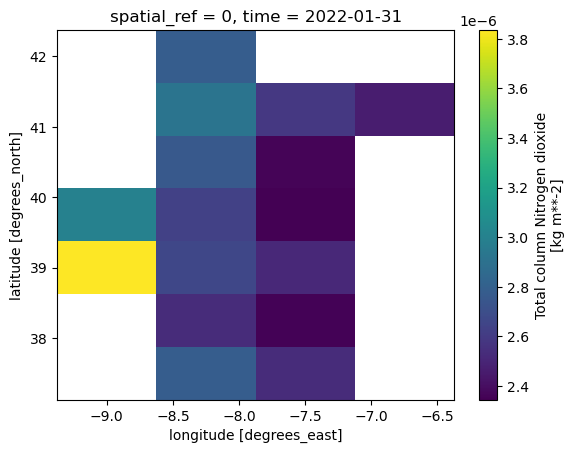

In [47]:
df2.rio.write_crs("epsg:4326", inplace=True)
#import shapefile and define reference system of shp
shapefile = gpd.read_file('C:/Users/User/AppData/Local/AtmosphericExplorer/shapefiles/portugal/prtgl.shp', crs="epsg:4326")
#clipping
df2_clip = df2.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)
df2_res =(df2_clip.resample(time="1M", restore_coord_dims=True).mean(dim='time'))
#simple plot
df2_res.tcno2[0].plot()

In [ ]:
df2 = df2.rio.write_crs('EPSG:4326')

In [ ]:
#all_touched=True questo parametro include tutti i pixel toccati dal poligono definito, se False include solo i pixel il cui centro è incluso nel poligono
#approvato all_touched=True
df2_clipped = df2.rio.clip(sh[sh['ADMIN'] == 'Portugal'].geometry.apply(mapping), sh.crs, drop=True, all_touched=True)

In [ ]:
df2_agg = df2_clipped.mean(dim=['latitude', 'longitude']).resample(time="1MS", restore_coord_dims=True).mean(dim='time')

In [ ]:
df2_agg

<xarray.Dataset>
Dimensions:      (time: 10)
Coordinates:
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-10-01
Data variables:
    tcno2        (time) float32 2.396e-06 2.379e-06 ... 2.583e-06 2.634e-06

In [ ]:
reference_value = df2_agg.mean(dim='time')

In [39]:
reference_value

array(3.3578537, dtype=float32)

In [40]:
df2_agg

<xarray.Dataset>
Dimensions:      (time: 10)
Coordinates:
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-10-01
Data variables:
    tcno2        (time) float32 2.396e-06 2.379e-06 ... 2.583e-06 2.634e-06

In [41]:
df2_agg_convert = convert_units_array(df2_agg['tcno2'], 'total_column_nitrogen_dioxide')

In [42]:
reference_value = df2_agg_convert.mean().values

In [43]:
df2_agg_anomalies = df2_agg_convert - reference_value
df2_agg_anomalies.attrs = df2_agg_convert.attrs

In [44]:
df2_agg_convert

<xarray.DataArray 'tcno2' (time: 10)>
array([3.136512 , 3.1134927, 3.3807724, 3.2283022, 3.3032248, 3.144131 ,
       3.691523 , 3.7528539, 3.3807929, 3.446931 ], dtype=float32)
Coordinates:
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-10-01
Attributes:
    units:    10^15 molecules / cm2

In [45]:
fig = px.line(
    y=df2_agg_anomalies.values,
    x=df2_agg_anomalies.coords['time'],
    markers='o'
)
fig.update_xaxes(title="Month")
fig.update_yaxes(title=df2_agg_anomalies.attrs['units'])
fig.update_layout(
    title={
        "text": "Total columns N02 above Portugal (anomalies)",
        "x": 0.45,
        "y": 0.95,
        "automargin": True,
        "yref": "container",
        "font": {
            "size":19
        }
    }
)

## Third plot

In [ ]:
fig = eac4_hovmoeller_levels_plot(
    'ozone',
    'go3',
    '2021-01-01/2021-04-01',
    '00:00',
    ['1','5', '10', '50', '100', '250', '500', '1000'],
    ['Italy'],
    "Ozone levels above Italy"
)
fig.show()

## Fourth plot
Hovmoeller O3

In [ ]:
o3_manager = EAC4Instance(
    'total_column_ozone',
    'netcdf',
    dates_range = '2020-01-01/2022-12-31',
    time_values = '00:00',
)
o3_manager.download()

In [ ]:
df_o3 = xr.open_dataset(o3_manager.file_full_path)
df_o3 = df_o3.rio.write_crs('EPSG:4326')
df_o3

In [ ]:
df_o3_agg = df_o3.resample(time="1MS", restore_coord_dims=True).mean(dim='time').mean(dim='longitude')
df_o3_convert = convert_units_array(df_o3_agg['gtco3'], 'total_column_ozone')

In [ ]:
df_o3_convert

In [ ]:
my_colorsc=[[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']]

In [ ]:
fig = px.imshow(df_o3_convert.T, color_continuous_scale='Jet', origin='lower')
fig.show()

In [ ]:
color_scale = px.colors.sequential.Jet
num_colors = 16
if num_colors > len(color_scale):
    interpolated_colors = []
    for i in range(num_colors):
        index = int(i * (len(color_scale) - 1) / (num_colors - 1))
        interpolated_colors.append(color_scale[index])
    discrete_colors = interpolated_colors
else:
    discrete_colors = color_scale

# import matplotlib.colors as mcolors
# if num_colors > len(color_scale):
#     cmap = mcolors.LinearSegmentedColormap.from_list('custom_color_scale', color_scale)
#     interpolated_colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, num_colors)]
#     discrete_colors = interpolated_colors
# else:
#     discrete_colors = color_scale

# if num_colors > len(color_scale):
#     discrete_colors = []
#     for i in range(num_colors):
#         ratio = i / (num_colors - 1)
#         idx = int(ratio * (len(color_scale) - 1))
#         discrete_colors.append(color_scale[idx])
# else:
#     discrete_colors = color_scale[:num_colors]

# import matplotlib.colors as mcolors
# cmap = mcolors.LinearSegmentedColormap.from_list('custom_color_scale', color_scale)
# interpolated_colors = [mcolors.rgb2hex(cmap(i / (num_colors - 1))) for i in range(num_colors)]

""" import plotly.colors as pcolors
if num_colors > len(color_scale):
    interpolated_colors = pcolors.interpolate_colorscale(color_scale, num_colors)
    discrete_colors = [c for c, _ in interpolated_colors]
else:
    discrete_colors = color_scale[:num_colors] """

fig = px.imshow(df_o3_convert.T, color_continuous_scale=discrete_colors)
fig.show()

## Plot 3


In [ ]:
multilevel_manager = EAC4Instance(
    'ozone',
    'netcdf',
    pressure_level =['1','5', '10', '50', '100', '250', '500', '1000'],
    dates_range = '2020-01-01/2020-06-30',
    time_values = '00:00',
)
multilevel_manager.download()

In [ ]:
print(multilevel_manager.file_full_path)

In [ ]:
df_ml = xr.open_dataset(multilevel_manager.file_full_path)
df_ml = df_ml.rio.write_crs('EPSG:4326')
df_ml

In [ ]:
df_ml_shifted=ds_swaplon(df_ml)

In [ ]:
sh_down = ShapefilesDownloader(
    resolution='10m',
    instance='countries'
)
sh_down.download_shapefile()

In [ ]:
sh = gpd.read_file(sh_down.shapefile_full_path, crs='EPSG:4326')

In [ ]:

df_ml_clipped = df_ml_shifted.rio.clip(sh[sh['ADMIN'] == 'Italy'].geometry.apply(mapping), sh.crs, drop=True, all_touched=True)

In [ ]:
df_ml_agg = df_ml_shifted.resample(time="1W", restore_coord_dims=True).mean(dim='time').mean(dim='longitude').mean(dim='latitude').sortby("level")
df_ml_convert = convert_units_array(df_ml_agg['go3'], 'ozone')

In [ ]:
df_ml_convert

In [ ]:
fig = px.imshow(df_ml_convert.T, color_continuous_scale='RdBu_r', origin='lower')
fig.update_yaxes(type='log', autorange='reversed')
fig.update_layout(
    title={
        "text": "Italy Vertical hovmoeller plots of ozone",
        "x": 0.45,
        "y": 0.95,
        "automargin": True,
        "yref": "container",
        "font": {
            "size":19
        }
    }
)
fig.show()